In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
# physio_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Physio/periods/features_segm_1.csv"
# driving_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"
# pvt_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [39]:
driving_path = "../Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(driving_path)

print(data.shape)

(58, 15)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             58 non-null     int64  
 1   label_sleep            58 non-null     int64  
 2   label_first_scenario   58 non-null     object 
 3   label_time_exp         58 non-null     int64  
 4   period                 58 non-null     object 
 5   TO_Decision_Rural      58 non-null     int64  
 6   TO_RT_Rural            58 non-null     float64
 7   TO_MaxSWA_Rural        58 non-null     float64
 8   TO_ReengageTime_Rural  40 non-null     float64
 9   TO_MaxBraking_Rural    58 non-null     float64
 10  TO_Decision_Urban      49 non-null     float64
 11  TO_RT_Urban            49 non-null     float64
 12  TO_MaxSWA_Urban        49 non-null     float64
 13  TO_ReengageTime_Urban  39 non-null     float64
 14  TO_MaxBraking_Urban    49 non-null     float64
dtypes: float

In [6]:
data.head()

,subject_id,label_sleep,label_first_scenario,label_time_exp,period,TO_Decision_Rural,TO_RT_Rural,TO_MaxSWA_Rural,TO_ReengageTime_Rural,TO_MaxBraking_Rural,TO_Decision_Urban,TO_RT_Urban,TO_MaxSWA_Urban,TO_ReengageTime_Urban,TO_MaxBraking_Urban
0,1,0,Countryside,16,Country,1,2.450,5.0,12.399,100.0,1.0,1.484,1.0,9.900,100.0
1,2,1,Urban,16,Country,4,2.900,2.0,3.233,0.0,NaN,NaN,NaN,NaN,NaN
2,3,0,Countryside,16,Country,1,2.233,7.0,25.767,100.0,1.0,2.918,5.0,14.068,95.2
3,4,1,Countryside,16,Country,4,1.665,37.0,NaN,100.0,1.0,1.467,10.0,NaN,100.0
4,5,0,Countryside,10,Country,1,1.467,6.0,3.750,100.0,NaN,NaN,NaN,NaN,NaN


In [7]:
label_counts = data["label_sleep"].value_counts()
print(label_counts)

label_sleep
1    31
0    27
Name: count, dtype: int64


C:\Users\kahch\AppData\Local\Temp\ipykernel_168692\3141730654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


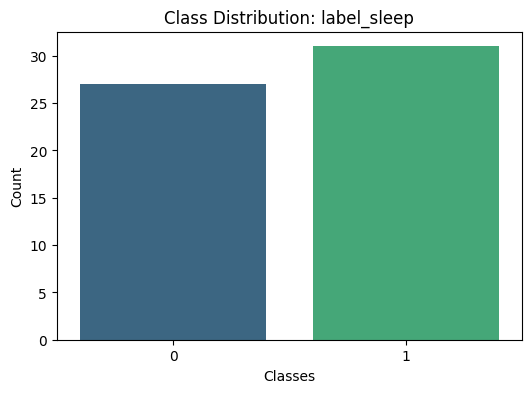

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Class Distribution: label_sleep")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


#Data Preprocessing

In [ ]:
columns_to_exclude = data.columns[data.isnull().mean() > 0.5]
data = data.drop(columns=columns_to_exclude)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_data = data.select_dtypes(include=['number'])

missing_values = numerical_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

data.fillna(numerical_data.mean(), inplace=True)

missing_after = data.isnull().sum()
print("\nMissing Values After Filling:\n", missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\nAll missing values have been successfully filled!")
else:
    print("\nThere are still missing values in the dataset.")

Missing Values:
 TO_ReengageTime_Rural    18
TO_Decision_Urban         9
TO_RT_Urban               9
TO_MaxSWA_Urban           9
TO_ReengageTime_Urban    19
TO_MaxBraking_Urban       9
dtype: int64

Missing Values After Filling:
 Series([], dtype: int64)

All missing values have been successfully filled!


In [10]:
data["label_first_scenario"] = data["label_first_scenario"].map({"Countryside": 0, "Urban": 1})
data["period"] = data["period"].map({"Country": 0, "Urban": 1})

print("\n'label_first_scenario' Column After Encoding:\n", data["label_first_scenario"].head())
print("\n'period' Column After Encoding:\n", data["period"].head())


'label_first_scenario' Column After Encoding:
 0    0
1    1
2    0
3    0
4    0
Name: label_first_scenario, dtype: int64

'period' Column After Encoding:
 0    0
1    0
2    0
3    0
4    0
Name: period, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label_sleep"] = label_encoder.fit_transform(data["label_sleep"])

print("Encoded Labels:\n", data["label_sleep"].unique())

Encoded Labels:
 [0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X = data.drop(columns=['subject_id', 'label_sleep']).values
y = data['label_sleep'].values

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {x_train.shape}")
print(f"Testing Set Size: {x_test.shape}")

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

Training Set Size: (46, 13)
Testing Set Size: (12, 13)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

input_size = x_train_norm.shape[1]
output_size = y_train.shape[1]

model = models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=(input_size,)),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.5),
    
    layers.Dense(output_size, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train_norm, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(x_test_norm, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

val_loss, val_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred = model.predict(x_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/150


c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4461 - loss: 8.2779 - val_accuracy: 0.6667 - val_loss: 8.0372
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4855 - loss: 8.0380 - val_accuracy: 0.5833 - val_loss: 7.8402
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5145 - loss: 7.8702 - val_accuracy: 0.5833 - val_loss: 7.6486
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4606 - loss: 7.6995 - val_accuracy: 0.5833 - val_loss: 7.4606
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5892 - loss: 7.4260 - val_accuracy: 0.5833 - val_loss: 7.2767
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5000 - loss: 7.2939 - val_accuracy: 0.5833 - val_loss: 7.0965
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4959 - loss: 7.1520 - val_accuracy: 0.5833 - val_loss: 6.9206
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5643 - loss: 6.9219 - val_accuracy: 0.5833 - val_loss: 6.7484
Epo

In [14]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

accuracy = accuracy_score(y_true_classes, y_pred_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      1.00      0.67         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

Accuracy: 0.50
ROC-AUC Score: 0.56
Precision: 0.25
Recall: 0.50
F1-Score: 0.33


c:\Users\kahch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kahch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kahch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kahch\anaconda3\Lib\site-packag

<Figure size 1000x800 with 0 Axes>

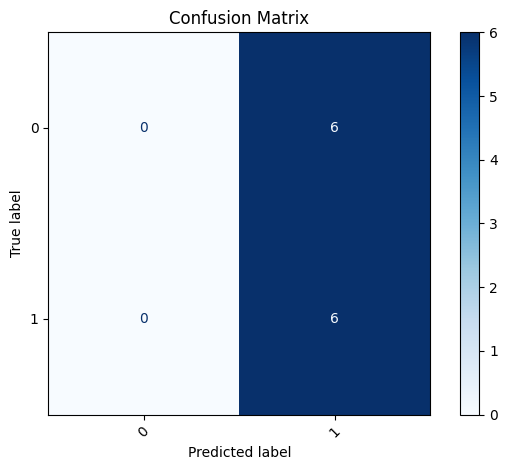

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

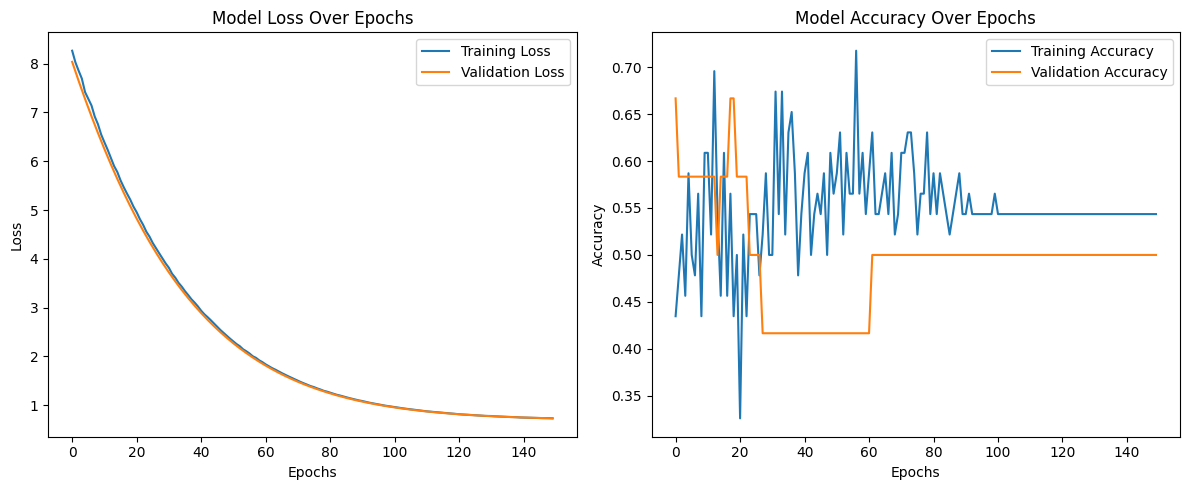

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

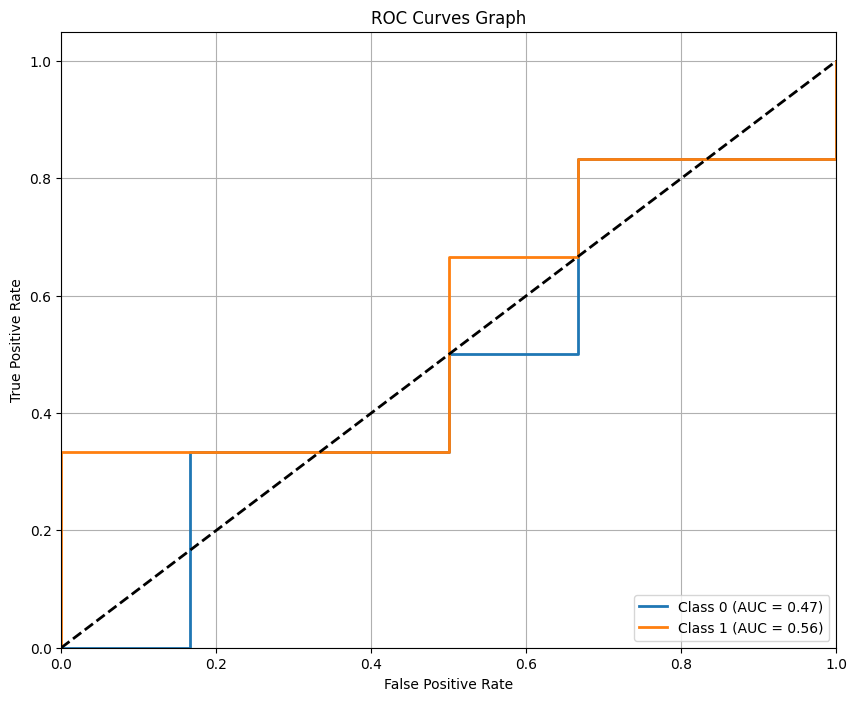

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

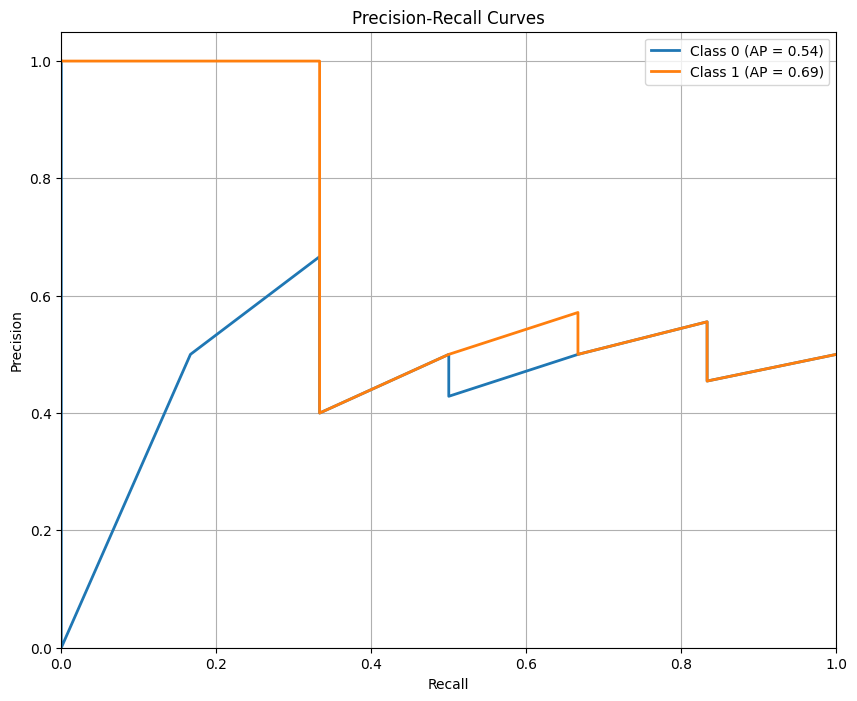

In [18]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [19]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
    input_size = x_train_norm.shape[1]
    output_size = y_train.shape[1]

    model = models.Sequential()

    model.add(layers.Dense(
        units=hp.Choice('units_1', values=[64, 128, 256]),
        activation='relu',
        input_shape=(input_size,)
    ))
    model.add(layers.Dropout(hp.Choice('dropout_1', values=[0.2, 0.3, 0.4])))

    model.add(layers.Dense(
        units=hp.Choice('units_2', values=[32, 64, 128]),
        activation='relu'

    ))
    model.add(layers.Dropout(hp.Choice('dropout_2', values=[0.2, 0.3, 0.4])))

    model.add(layers.Dense(
        units=hp.Choice('units_3', values=[16, 32, 64]),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Choice('dropout_3', values=[0.2, 0.3, 0.4])))

    model.add(layers.Dense(output_size, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='NN_Tuning',
    project_name='NN_Hyperparameter_Tuning'
)

hyper_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


tuner.search(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"Units in Layer 1: {best_hps.get('units_1')}")
print(f"Dropout in Layer 1: {best_hps.get('dropout_1')}")
print(f"Units in Layer 2: {best_hps.get('units_2')}")
print(f"Dropout in Layer 2: {best_hps.get('dropout_2')}")
print(f"Units in Layer 3: {best_hps.get('units_3')}")
print(f"Dropout in Layer 3: {best_hps.get('dropout_3')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

y_pred_best = best_model.predict(x_test_norm)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)
y_true_best_classes = np.argmax(y_test, axis=1)

Trial 90 Complete [00h 00m 05s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 03m 51s

Best Hyperparameters:
Units in Layer 1: 64
Dropout in Layer 1: 0.4
Units in Layer 2: 64
Dropout in Layer 2: 0.4
Units in Layer 3: 64
Dropout in Layer 3: 0.4
Learning Rate: 0.005
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3899 - loss: 0.7687 - val_accuracy: 0.5000 - val_loss: 0.6763
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4710 - loss: 0.7146 - val_accuracy: 0.5000 - val_loss: 0.6769
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4606 - loss: 0.7256 - val_accuracy: 0.5000 - val_loss: 0.6755
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4502 - loss: 0.7434 - val_accuracy: 0.5833 - val_loss: 0.6725
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6101 - loss: 0.6904 - val_accuracy: 0.5833 - val_loss: 0.6683
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy:

In [21]:
print("Classification Report:\n")
print(classification_report(y_true_best_classes, y_pred_best_classes))

accuracy = accuracy_score(y_true_best_classes, y_pred_best_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_best_classes, y_pred_best[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred_best, multi_class='ovr', average='weighted')

precision = precision_score(y_true_best_classes, y_pred_best_classes, average='macro')
recall = recall_score(y_true_best_classes, y_pred_best_classes, average='macro')
f1 = f1_score(y_true_best_classes, y_pred_best_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

Accuracy: 0.83
ROC-AUC Score: 0.72
Precision: 0.83
Recall: 0.83
F1-Score: 0.83


<Figure size 1000x800 with 0 Axes>

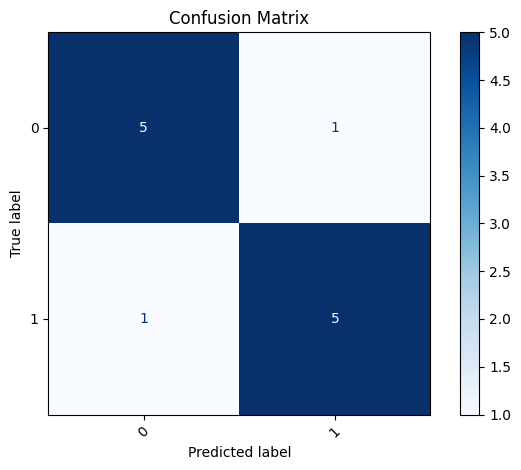

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_best_classes, y_pred_best_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

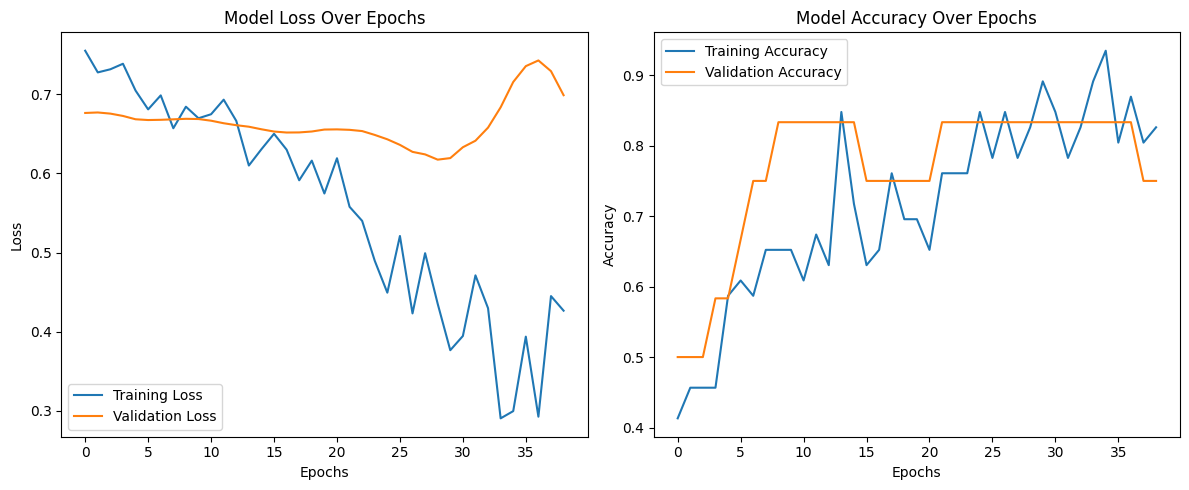

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

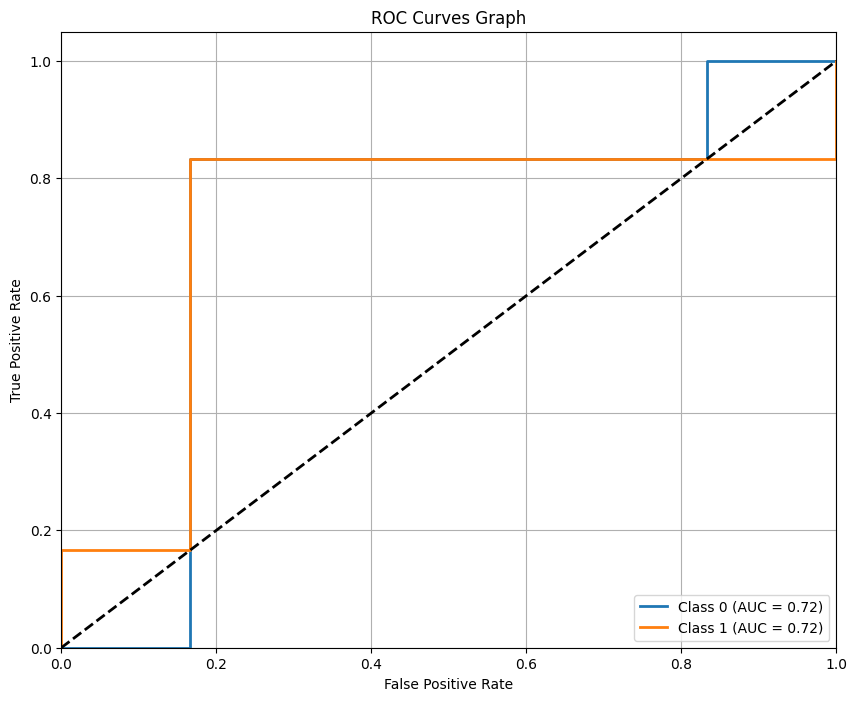

In [24]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

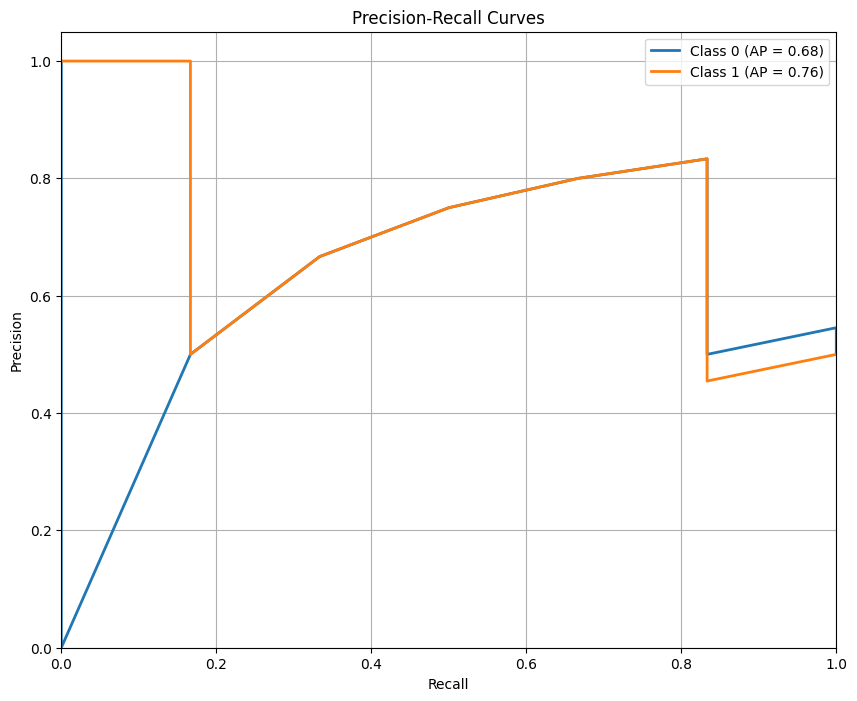

In [25]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_best[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_best[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,584 (142.91 KB)

 Trainable params: 12,194 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,390 (95.28 KB)

In [27]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,040 (109.54 KB)

 Trainable params: 9,346 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,694 (73.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


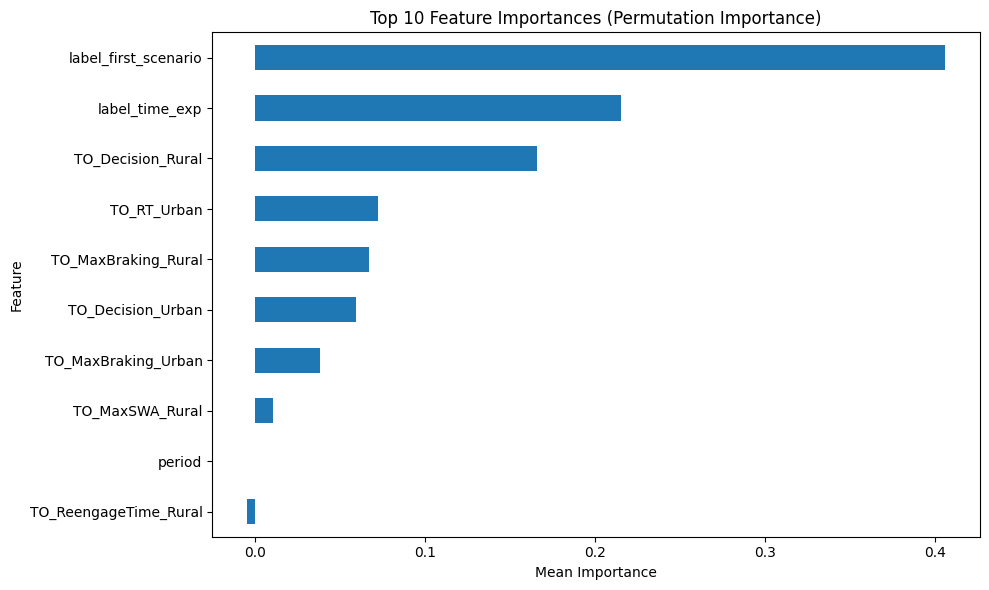

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

perm_importance = permutation_importance(
    best_model,
    x_test_norm,
    y_test,
    scoring=scoring,
    n_repeats=1,
    random_state=42
)

feature_names = data.drop(columns=['subject_id', 'label_sleep']).columns

feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance['r2']['importances_mean']
}).sort_values(by="Importance", ascending=False)

feature_importances.head(10).plot(
    kind="barh",
    x="Feature",
    y="Importance",
    legend=False,
    figsize=(10, 6)
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
import shap

subset_data = x_test_norm

explainer = shap.DeepExplainer(model, subset_data)

shap_values = explainer.shap_values(subset_data)

c:\Users\kahch\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 13))']
  warnings.warn(msg)
c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(24, 13))']
  warnings.warn(msg)


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


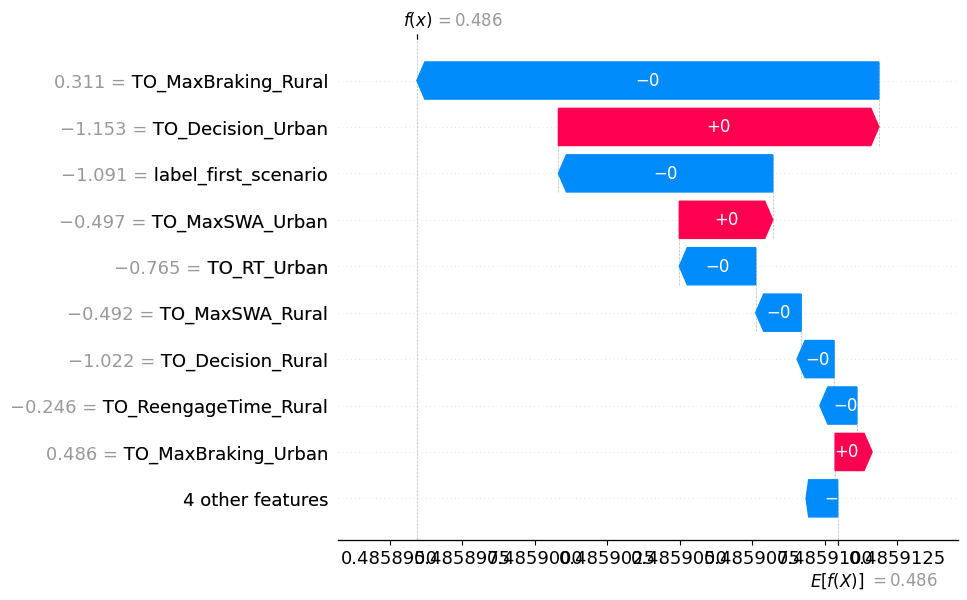

In [ ]:
expected_value = explainer.expected_value[0].numpy()

feature_names = data.drop(columns=['subject_id', 'label_sleep']).columns

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0, :, 0],
        base_values=expected_value,
        data=subset_data[0],
        feature_names=feature_names.tolist()
    )
)

In [ ]:
shap.initjs()

shap.plots.force(
    expected_value,
    shap_values[:, :, 0],
    subset_data,
    feature_names=feature_names
)

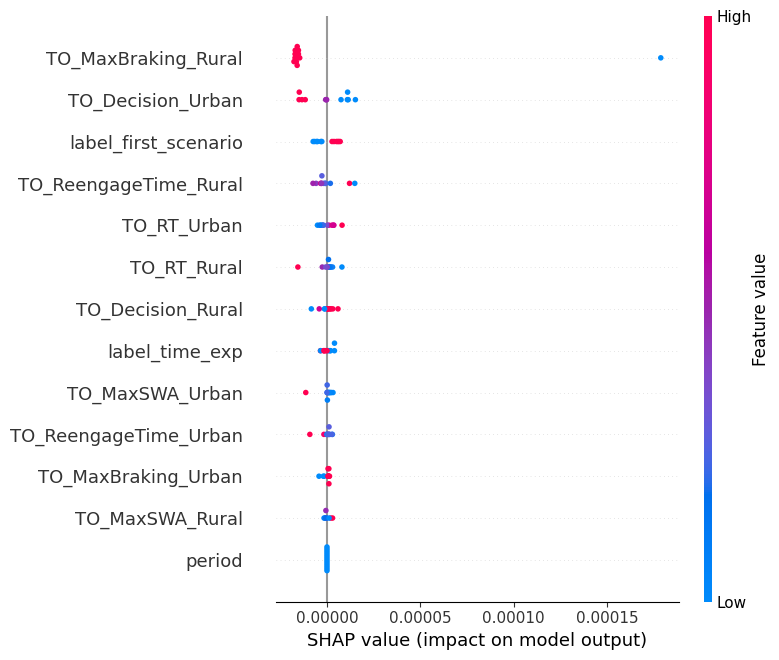

In [ ]:
shap.summary_plot(
    shap_values[:, :, 0],
    subset_data,
    feature_names=feature_names.tolist()
)

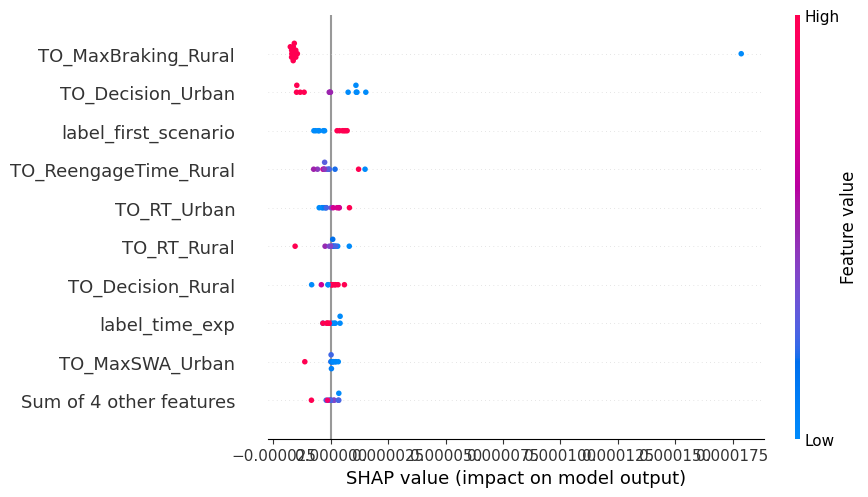

In [ ]:
shap_exp = shap.Explanation(
    values=shap_values[:, :, 0],
    base_values=expected_value,
    data=subset_data,
    feature_names=feature_names.tolist()
)

shap.plots.beeswarm(shap_exp)

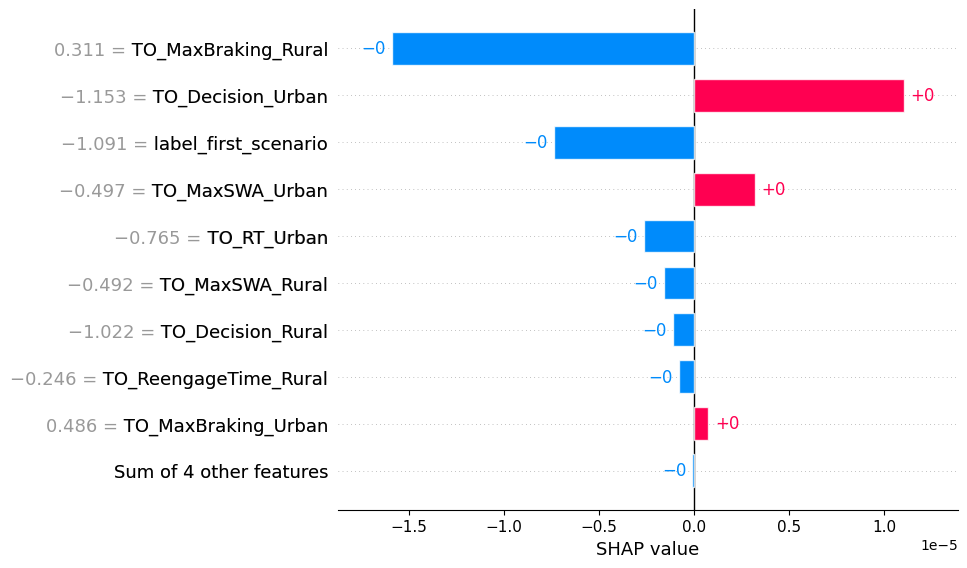

In [ ]:
shap.plots.bar(
    shap.Explanation(
        values=shap_values[0, :, 0],
        base_values=expected_value,
        data=subset_data[0],
        feature_names=feature_names.tolist()
    )
)

In [35]:
pip install quantus

Note: you may need to restart the kernel to use updated packages.


c:\Users\kahch\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\kahch\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\kahch\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


  0%|          | 0/1.0 [00:00<?, ?it/s]

c:\Users\kahch\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(12, 13))']
  warnings.warn(msg)
c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(24, 13))']
  warnings.warn(msg)


Robustness Score: 0.1569


  0%|          | 0/1.0 [00:00<?, ?it/s]

Complexity Score: 0.6202


  0%|          | 0/48 [00:00<?, ?it/s]

c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(12, 13))']
  warnings.warn(msg)
c:\Users\kahch\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(24, 13))']
  warnings.warn(msg)


Randomisation Score: 0.6230


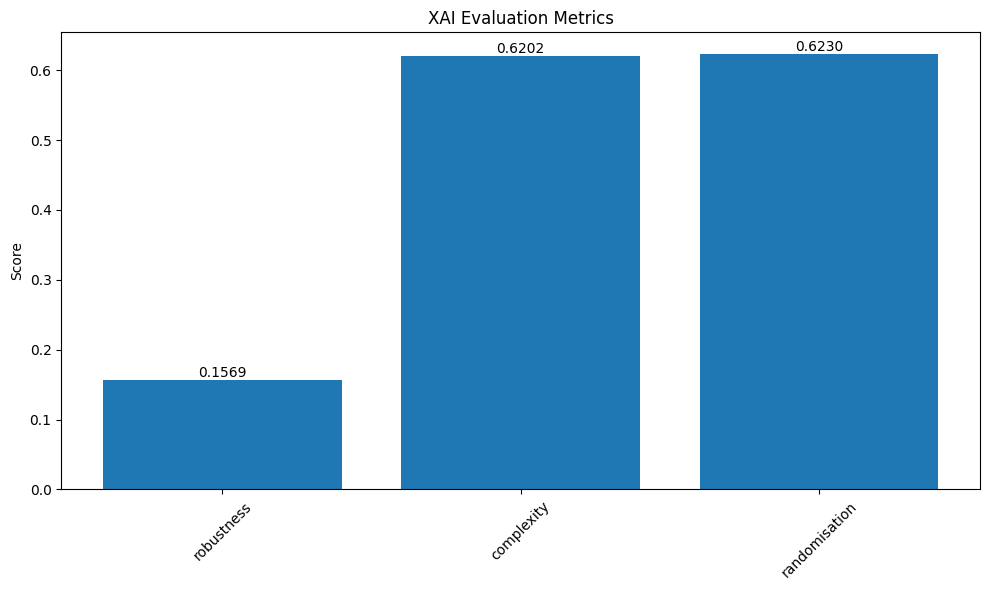

In [36]:
import quantus

def shap_explain_func(model, inputs, targets, **kwargs):
    background = inputs[:100]

    explainer = shap.DeepExplainer(model, background)

    shap_values = explainer.shap_values(inputs)

    explanations = shap_values[:, :, 0]
    
    return explanations

def evaluate_xai_metrics(x_batch: np.ndarray, y_batch: np.ndarray, 
                        attributions: np.ndarray, n_samples):

    x_batch = x_batch[:n_samples]
    y_batch = y_batch[:n_samples]
    attributions = attributions[:n_samples]
    
    metrics = {
        "robustness": quantus.AvgSensitivity(
            nr_samples=2,
            lower_bound=0.2,
            norm_numerator=quantus.norm_func.fro_norm,
            norm_denominator=quantus.norm_func.fro_norm,
            perturb_func=quantus.perturb_func.uniform_noise,
            similarity_func=quantus.similarity_func.difference,
            abs=True,
            normalise=False,
            aggregate_func=np.mean,
            return_aggregate=True,
            disable_warnings=True,
            display_progressbar=True,
        ),
        "complexity": quantus.Sparseness(
            abs=True,
            normalise=True,
            disable_warnings=True,
            display_progressbar=True,
            return_aggregate=True,
        ),
        "randomisation": quantus.MPRT(
            similarity_func=quantus.similarity_func.correlation_spearman,
            return_average_correlation=True,
            aggregate_func=np.mean,
            layer_order="independent",
            disable_warnings=True,
            normalise=True,
            abs=True,
            display_progressbar=True,
        )
    }

    results = {}
    for metric_name, metric in metrics.items():
        score = metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=attributions,
            explain_func=shap_explain_func
        )
        score_value = np.mean(score) if isinstance(score, (np.ndarray, list)) else score
            
        results[metric_name] = score_value
        print(f"{metric_name.capitalize()} Score: {score_value:.4f}")
            
    return results

def plot_metric_results(results):
    results = {k: v for k, v in results.items() if v is not None}
        
    plt.figure(figsize=(10, 6))
    metrics = list(results.keys())
    scores = list(results.values())
    
    bars = plt.bar(metrics, scores)
    plt.title('XAI Evaluation Metrics')
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


y_test_classes = np.argmax(y_test, axis=1)

results = evaluate_xai_metrics(
    x_batch=x_test_norm,
    y_batch=y_test_classes,
    attributions=shap_values[:, :, 0],
    n_samples=100
)

plot_metric_results(results)